In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer
from xgboost import XGBRegressor, DMatrix
import xgboost as xgb
import matplotlib.pyplot as plt
import keras
import albumentations as A
import numpy as np
import glob
import cv2
import os
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import make_scorer
import math
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import statistics
from tqdm.notebook import tqdm
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')


In [2]:
class DataGenerator(keras.utils.Sequence):

    
    def __init__(self, batch_size=5, dim=(250,250),  X_n_channels=73, shuffle=True, y_n_channels=1, 
                 
                 X_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/X_test/',
                 y_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/Y_test/',
                
                ):
        
        # this is the dim before padding
        
        self.dim = dim
        self.batch_size = batch_size
        self.X_n_channels = X_n_channels
        self.y_n_channels = y_n_channels
        self.shuffle = shuffle
        
        
        self.X_dir = X_test_dir
        self.y_dir = y_test_dir
        self.list_IDs = self.read_in_list_of_ids(X_test_dir)
        

        self.on_epoch_end()

        
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    
    def __getitem__(self, index):
        '''Generate one batch of data'''
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    
    def on_epoch_end(self):
        '''Updates indexes after each epoch'''
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization        
        X = np.empty((self.batch_size, *self.dim, self.X_n_channels))
        y = np.empty((self.batch_size, *self.dim, self.y_n_channels))
        

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # Store sample
            X[i,] = np.load(self.X_dir + 'X_' + ID)
                
            # Store class
            temp_y = np.load(self.y_dir + 'Y_' + ID)

            # replace missing values with a height of 0 
            y[i,] = np.where(temp_y==-32767.0, 0, temp_y) 
        
            
            
        return X, y
    
    
    @staticmethod
    def read_in_list_of_ids(directory):
        '''
        the format of image names is as follows for both X and Y X/Y_TileId_X1_X2_Y1_Y2.npy
        create a list from either directory as follows _TileId_X1_X2_Y1_Y2.npy
        so that we can shuffle and select image pairs in the image generator.
        '''
        list_of_ids = []

        for filepath in glob.glob(directory + '*.npy'):
            filename = filepath.split('\\')[1]
            parsed_filename = '_'.join(filename.split('_')[1:])
            list_of_ids.append(parsed_filename)

        return list_of_ids
    
    
    



# Xgboost-Model

In [3]:
important_features = ['X','Y','tile','Height',
                     '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD', '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc', '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN', 
                     '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL', 
                     '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0005_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0002_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_DIL_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0012_OPN', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0003_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_ERO_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0012_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0005_DIL_asc', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0007_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_ERO', '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0006_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_OPN_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0007_DIL', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0004_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_GRD', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_OPN_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0004_DIL', '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0012_OPN', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW2_STM_B0002_ERO', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0009_DIL', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_CLS_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_OPN', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0003_DIL_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0007_GRD', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_CLS_asc', '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0011_GRD', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0004_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0012_CLS', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0008_GRD_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_GRD_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0001_CLS', '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_OPN', 
                     '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_BHT', '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0003_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_CLS', '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0011_CLS', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0009_ERO_asc', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_CLS_asc', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0007_ERO', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0013_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO', '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc', '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO', 
                     '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO', '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc', 
                     '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc', '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO']



filepath = 'C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/building_height_sample_asc.csv'
data = pd.read_csv(filepath)
print(data.shape)
data = data[important_features]
# filter out zeros and the tallest building in Ireland which is 50 metres taller
# than nearest neighbour
data = data[(data.Height > 0) & (data.Height < 100)]
data.head()

(939996, 77)


X     Y         tile  Height  \
0  2161  2579  X0002_Y0002       2   
1  2135  2515  X0002_Y0002       2   
2  2159  2579  X0002_Y0002       2   
3  2163  2570  X0002_Y0002       2   
4  2105  2526  X0002_Y0002       2   

   2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD  \
0                                               803   
1                                              2730   
2                                               803   
3                                              3961   
4                                              6455   

   2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO  \
0                                              6956   
1                                              5894   
2                                              6956   
3                                              3959   
4                                              1094   

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc  \
0                                                849      
1                                                430      
2                                                776      
3                                                816      
4                                                465      

   2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS  \
0                                              1850   
1                                              2361   
2                                              1795   
3                                              1674   
4                                              2118   

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc  \
0                                             -15737      
1                                             -15451      
2                                             -15737      
3                                             -16488      
4                                             -14625      

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc  ...  \
0                                               4941     ...   
1                                               3007     ...   
2                                               4941     ...   
3                                               1576     ...   
4                                               3862     ...   

   2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO  \
0                                              1762   
1                                              1110   
2                                              1683   
3                                              1489   
4                                              1128   

   2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO  \
0                                               199   
1                                                92   
2                                               193   
3                                               278   
4                                               102   

   2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc  \
0                                               4254      
1                                               7549      
2                                               4641      
3                                               2505      
4                                               5076      

   2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN  \
0                                               295   
1                                               191   
2                                               278   
3                                               331   
4                                               188   

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc  \
0                                             -16972      
1                                             -16922      
2                                             -17682      
3                                             -17571      
4                                             

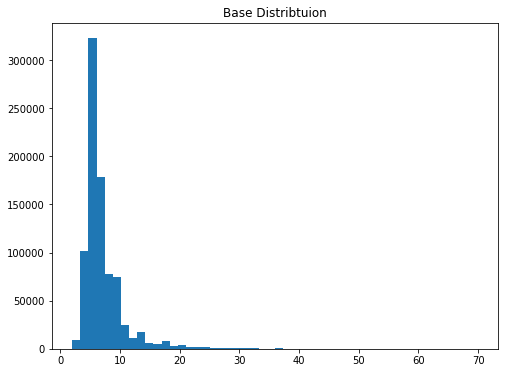

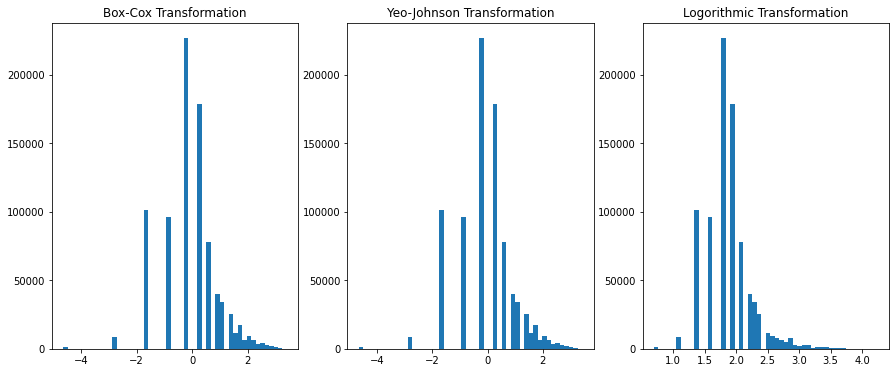

In [4]:
from scipy.stats import anderson, normaltest, shapiro

def take_logarithm(array, zero=False):
    
    if type(array) is np.ndarray:
        
        if not zero:
            return np.log(array)
        else:
            return np.log(array+1)
    
    else:
        array = np.array(array)
        
        if not zero:
            return np.log(array)
        
        else:
            return np.log(array+1)
    
    
def Anderson_Darling(array, p=0.05):

    result = anderson(array)
    print('Statistic: %.3f' % result.statistic)
    
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < result.critical_values[i]:
            print('%.3f: %.3f, Anderson_Darling data looks normal (fail to reject H0)' % (sl, cv))
        else:
            print('%.3f: %.3f, Anderson_Darling data does not look normal (reject H0)' % (sl, cv))
            

def D_Agostino_K_2(array, alpha=0.05):
    
    stat, p = normaltest(array)
    print('Statistics=%.3f, p=%.3f' % (stat, p))

    if p > alpha:
        print(' D_Agostino_K_2 Sample looks Gaussian (fail to reject H0)')
    else:
        print('D_Agostino_K_2 Sample does not look Gaussian (reject H0)')
        
        
def shapiro(array, alpha=0.05):
    
    stat, p = shapiro(array)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret

    if p > alpha:
        print('shapiro Sample looks Gaussian (fail to reject H0)')
    else:
        print('shapiro Sample does not look Gaussian (reject H0)')

        
def check_normality(array):
    #shapiro(array)
    D_Agostino_K_2(array)
    Anderson_Darling(array)
    
    
def check_if_zeros_or_negatives(array):
    
    if np.any(array == 0):
        return 'zero'
    
    elif np.any(array < 0):
        return 'negative'
    
    else:
        return 'positive-no-zero'


def plot_transformations(array, bins=50):
    
    # plot the base distrbution
    plt.figure(figsize=(8,6))
    plt.title('Base Distribtuion')
    plt.hist(array, bins=bins) 
    plt.show()
    
    flag = check_if_zeros_or_negatives(array)
    
    
    if flag == 'negative':
        print('Array has negative Values')
        yeo_johnson = PowerTransformer(method='yeo-johnson').fit_transform(array)
        
        plt.figure(figsize=(8,8))
        plt.title('Yeo-Johnson Transformation')
        plt.hist(yeo_johnson, bins=bins) 
        plt.show()
 
        
    else:
        
        box_cox = PowerTransformer(method='box-cox').fit_transform( array.reshape(-1, 1) + 1 )
        yeo_johnson = PowerTransformer(method='yeo-johnson').fit_transform( array.reshape(-1, 1) )
        
        if flag == 'zero':
            print('Array has zeros')
            logarithm = take_logarithm(array, zero=True)
        else:
            logarithm = take_logarithm(array)
            
        
        fig = plt.figure(figsize=(15, 6))
        ax1 = fig.add_subplot(1,3,1)
        ax1.set_title("Box-Cox Transformation")
        ax1.hist(box_cox, bins=bins) 
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.set_title("Yeo-Johnson Transformation")
        ax2.hist(yeo_johnson, bins=bins)
        
        ax3 = fig.add_subplot(1,3,3)
        ax3.set_title("Logorithmic Transformation")
        ax3.hist(logarithm, bins=bins) 
        

heights = data['Height'].values
plot_transformations(heights) 

# HyperParameter Tuning

In [28]:
search_space = {
                'n_estimators': [50, 100, 150, 200],
                'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                'max_depth': [ 3, 4, 5, 6, 8],
                'colsample_bytree': [ 0.3, 0.4, 0.5 , 0.7 ],
                'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                'objective':['count:poisson','reg:gamma','reg:tweedie']
              }


def hyper_param_search(xgb_model, X, y, stratified, param_grid):
    
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
    rmse = []
    weighted_rmse = []
    model_params = []
    for train_index, test_index in tqdm(kfold.split(X, stratified)):
   
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        
        model = RandomizedSearchCV(xgb_model, param_grid, cv=5, scoring= 'neg_mean_absolute_error')
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
        params = model.best_params_
        error  = root_mean_squared_error(y_test, preds)
        weighted_error = weighted_root_mean_squared_error(y_test, preds)
        
        print(params)
        print(error)
        print(weighted_error)
        
        model_params.append(params)
        rmse.append(error)
        weighted_rmse.append(weighted_error)
        
    return model_params, rmse, weighted_rmse


base_model = XGBRegressor()
model_params, rmse, weighted_rmse = hyper_param_search(base_model, X, y, stratified, search_space)

|          | 0/? [00:00<?, ?it/s]

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [-2.43335984         nan -2.43273055 -2.42643812 -2.43682474 -2.44937791
 -4.28736791         nan -2.41751062 -2.47219077]
  category=UserWarning


{'objective': 'count:poisson', 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.1, 'colsample_bytree': 0.3}
3.170948120468781
2.0173949817202836


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -2.41246251 -2.44730564 -2.46640416 -2.44954032 -2.45821226
 -2.44361681 -2.42056054         nan -2.50812822]
  category=UserWarning


{'objective': 'reg:tweedie', 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.4}
3.2381428443107945
2.0970623451130623


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

{'objective': 'reg:tweedie', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.4}
3.28311424057085
2.089064739019362


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

{'objective': 'reg:tweedie', 'n_estimators': 50, 'max_depth': 4, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.4}
3.222881913082464
2.135833505436463


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

{'objective': 'reg:tweedie', 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.5}
3.0734742324324715
2.0670069417184274


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

{'objective': 'count:poisson', 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.3, 'gamma': 0.4, 'colsample_bytree': 0.3}
3.0157653562208258
2.0796668457755754


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

{'objective': 'count:poisson', 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.7}
2.9056488778026153
1.9797731147850475


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [-2.42011952 -2.45839032 -2.43960598         nan -2.42754696 -2.46017944
 -2.52382466 -2.5254712  -2.46321228 -2.42170562]
  category=UserWarning


{'objective': 'reg:tweedie', 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.4}
3.0364670427425335
1.9884338392399505


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_search.py:921: UserWarning: One or more of the test scores are non-finite: [        nan -2.44051499 -2.70308106 -2.40738253 -2.46572493         nan
 -2.51448225         nan -2.42923364 -2.45063457]
  category=UserWarning


{'objective': 'reg:tweedie', 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 0.4}
3.286457290851725
2.086804919771801


C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py:687: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 200, in __call__
    sample_weight=sample_weight)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_scorer.py", line 243, in _score
    **self._kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\egnke\PythonCode\MetEireann\Met_Eireann\lib\site-packages\sklearn\metrics\_re

{'objective': 'reg:tweedie', 'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.4}
3.1414544998122387
2.045193298092051


# Cross Validation

In [8]:
def replace_value_with_frequency_of_occurance(array):

    unique_elements, counts_elements = np.unique(array, return_counts=True)
    mapping = dict(zip(unique_elements, counts_elements))
    
    return np.vectorize(mapping.get)(array)


def weighted_root_mean_squared_error(y_actual, y_pred):
    weights = replace_value_with_frequency_of_occurance(y_actual)
    return np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))



def root_mean_squared_error(y_actual, y_pred):
    MSE = np.square(np.subtract(y_actual,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    return RMSE


def compute_class_weights(array, group_above_10m=True):
    
    if group_above_10m:
        array = np.where(array>10, 11, array)
        
    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(array),
                                                     array)

    class_weight_mapper = dict(zip(np.unique(array), class_weights))

    vectorized = np.vectorize(class_weight_mapper.get)(array)

    return vectorized


def cross_val_model(model, X, y, stratified, transform=True):
    
    kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
    
    rmse = []
    weighted_rmse = []
    for train_index, test_index in tqdm(kfold.split(X, stratified)):
       
        X_train, X_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
        y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]
        
        
        class_weights = compute_class_weights(y_train)

        
        if transform:
            y_train_nice_shape = y_train.values.reshape(-1,1)
            yeo_johnson = PowerTransformer(method='yeo-johnson').fit(y_train_nice_shape)
            y_train_transformed = yeo_johnson.transform(y_train_nice_shape)

            preds = model.fit(X_train, y_train_transformed).predict(X_test)
            
            if preds.ndim  == 2:
                preds = yeo_johnson.inverse_transform(preds).reshape(-1)
            else:
                preds = yeo_johnson.inverse_transform(preds.reshape(-1, 1)).reshape(-1)
        
        else:
            preds = model.fit(X_train, y_train, sample_weight=class_weights).predict(X_test)

        
        rmse.append(root_mean_squared_error(y_test, preds))
        weighted_rmse.append(weighted_root_mean_squared_error(y_test, preds))
        
    print(rmse)
    print('Average RMSE: ' + str(statistics.mean(rmse)) + ' STD: ' + str(statistics.stdev(rmse)))
    
    print('/n')
    print(weighted_rmse)
    print('Average weighted RMSE: ' + str(statistics.mean(weighted_rmse)) + ' STD: ' + str(statistics.stdev(weighted_rmse)))
    
    
bins     = np.arange(1,41)
bins[-1] = data.Height.max()
data['binned'] = pd.cut(data['Height'], bins)
data['stratified_labels'] = LabelEncoder().fit_transform(data['binned'])


y = data['Height']
stratified = data['stratified_labels']
X = data.drop(['X','Y','tile','Height','binned','stratified_labels'], axis=1)

params = {'max_depth': 6,
         'n_estimators':100,
         'learning_rate': 0.1,
         'gamma':'0.15000000000000002',
         'colsample_bytree':'0.45',
         }

class_weights = compute_class_weights(y)
sample_weight=class_weights

#linear_xgb  = XGBRegressor()
poisson_xgb  = XGBRegressor(**params)
linear_model = Ridge(alpha=0.01)

#cross_val_model(linear_model, X, y, stratified, transform=True)
cross_val_model(linear_model, X, y, stratified, transform=False)

#cross_val_model(poisson_xgb, X, y, stratified, transform=False)
#cross_val_model(poisson_xgb, X, y, stratified, transform=False)
#cross_val_model(poisson_xgb, X, y, stratified)

|          | 0/? [00:00<?, ?it/s]

[3.1111954154184795, 3.0849917171099155, 3.107026035620697, 3.108250750990699, 3.103504331642306, 3.0940549116859253, 3.090430389257318, 3.104320479773922, 3.1000950605921727, 3.10089201031982]
Average RMSE: 3.1004761102411256 STD: 0.008329547606959867
/n
[2.0951989864702103, 2.084048690703648, 2.095338467588317, 2.0917407222527338, 2.0888378297571735, 2.076070110876442, 2.0898613792468432, 2.0953868493531598, 2.087961281397931, 2.085918364564216]
Average weighted RMSE: 2.0890362682210677 STD: 0.006054704663845642


# Train Model

In [19]:
#y = data['Height']
#X = data.drop(['X','Y','tile','Height'], axis=1)

y_nice_shape = y.values.reshape(-1,1)
yeo_johnson = PowerTransformer(method='yeo-johnson').fit(y_nice_shape)
y_transformed = yeo_johnson.transform(y_nice_shape)

class_weights = compute_class_weights(y)

save=False
xgb = XGBRegressor(**params)
xgb.fit(X, y_transformed, sample_weight=class_weights)


linear_model = Ridge(alpha=0.01)
linear_model.fit(X, y_transformed, sample_weight=class_weights)

if save:
    xgb.save_model("xgb_building_height.json")

# Test on Unseen

In [20]:
filepath = 'C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/building_height_sample_asc_test.csv'
test = pd.read_csv(filepath)
test = test[important_features]
test.head()

X    Y         tile  Height  \
0   979  476  X0003_Y0003       3   
1  1318  470  X0003_Y0003       3   
2   986  473  X0003_Y0003       3   
3   982  469  X0003_Y0003       3   
4  1382  456  X0003_Y0003       3   

   2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD  \
0                                              4450   
1                                              7310   
2                                              5225   
3                                              4740   
4                                              7532   

   2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO  \
0                                              4335   
1                                              2167   
2                                              2706   
3                                              3756   
4                                              1854   

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc  \
0                                                377      
1                                                298      
2                                                377      
3                                                429      
4                                                369      

   2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS  \
0                                              2088   
1                                              1722   
2                                              1595   
3                                              1905   
4                                              4058   

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc  \
0                                              -9920      
1                                             -14642      
2                                             -13051      
3                                              -9920      
4                                              -4420      

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc  ...  \
0                                               9961     ...   
1                                               5480     ...   
2                                               4870     ...   
3                                               8374     ...   
4                                              14266     ...   

   2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO  \
0                                              1067   
1                                              1141   
2                                              1067   
3                                              1194   
4                                               865   

   2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO  \
0                                               118   
1                                                79   
2                                               140   
3                                               160   
4                                                55   

   2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc  \
0                                              13433      
1                                               8387      
2                                              10324      
3                                              12904      
4                                              14658      

   2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN  \
0                                               226   
1                                               129   
2                                               175   
3                                               226   
4                                               115   

   2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc  \
0                                             -14221      
1                                             -16646      
2                                             -15231      
3                                             -15024      
4                                             -15370

138
3.516058776477628


(array([9.72800e+03, 1.16100e+05, 3.71213e+05, 2.04869e+05, 8.83580e+04,
        8.31140e+04, 2.76670e+04, 1.25260e+04, 1.84460e+04, 6.90100e+03,
        5.53700e+03, 8.12900e+03, 2.83200e+03, 4.05800e+03, 1.49200e+03,
        1.45400e+03, 2.15800e+03, 8.88000e+02, 5.82000e+02, 1.08900e+03,
        4.12000e+02, 4.12000e+02, 6.90000e+02, 2.53000e+02, 2.13000e+02,
        3.64000e+02, 1.37000e+02, 2.77000e+02, 7.90000e+01, 4.80000e+01,
        1.09000e+02, 1.10000e+01, 1.00000e+01, 3.10000e+01, 9.00000e+00,
        3.10000e+01, 9.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 7.00000e+00, 0.00000e+00, 1.00000e+00, 8.00000e+00,
        2.00000e+00, 1.00000e+00, 2.30000e+01, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

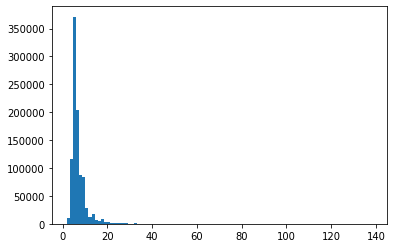

In [21]:
height_dist = y.tolist() + test['Height'].tolist()
height_dist = np.array(height_dist)
height_dist = height_dist[height_dist > 0]

print(np.max(height_dist))
print(np.std(height_dist))

plt.hist(height_dist, bins=100) 

In [22]:
def weighted_root_mean_squared_error(y_actual, y_pred):
    weights = replace_value_with_frequency_of_occurance(y_actual)
    return np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))

y_true = test['Height'].values
test.drop(['X','Y','tile','Height'],axis=1,inplace=True)
y_preds = xgb.predict(test)
y_preds = yeo_johnson.inverse_transform(y_preds.reshape(-1, 1)).reshape(-1)
print(weighted_root_mean_squared_error(y_true, y_preds))

1.9449874356516463


In [23]:
y_preds = linear_model.predict(test)

y_preds = yeo_johnson.inverse_transform(y_preds).reshape(-1)


print(weighted_root_mean_squared_error(y_true, y_preds))

nan


# Test Model

-----------------------------------------------------------------------------------------------
Total RMSE is: 2.0944620348423064
Total WRMSE is: 1.339123948932508


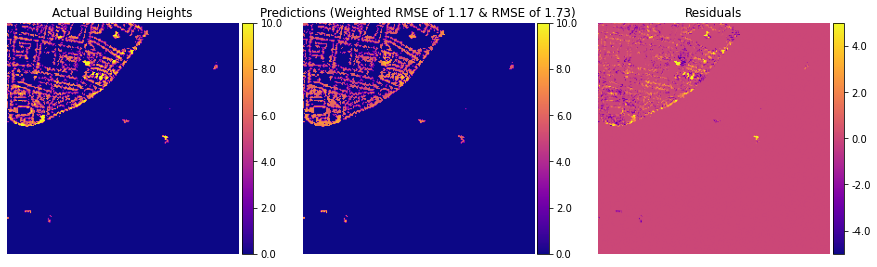

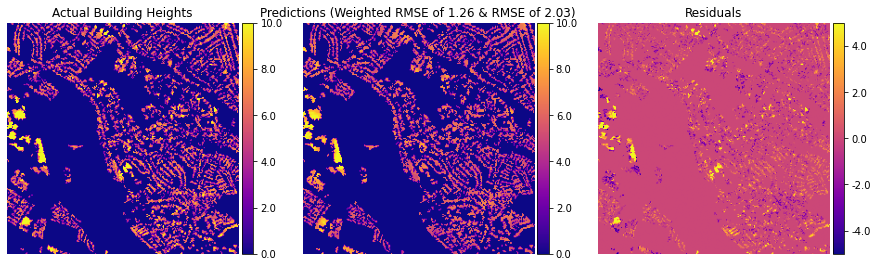

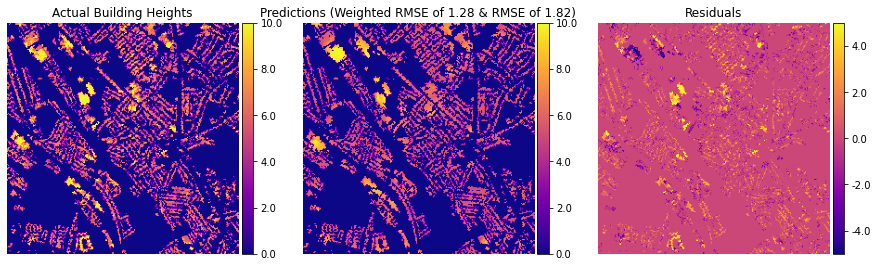

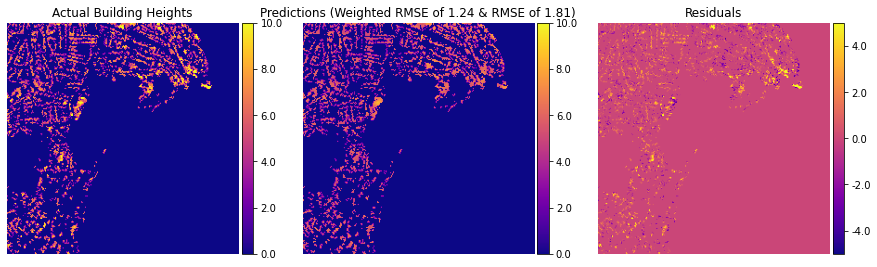

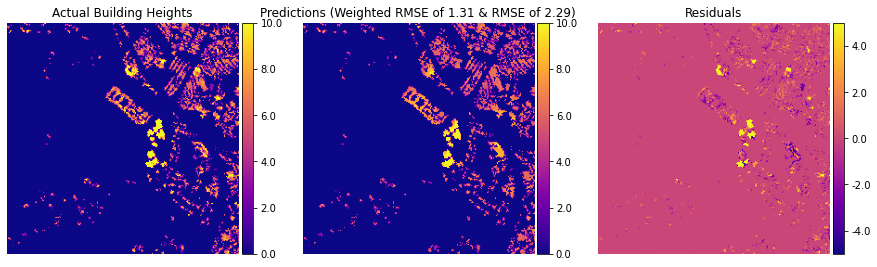

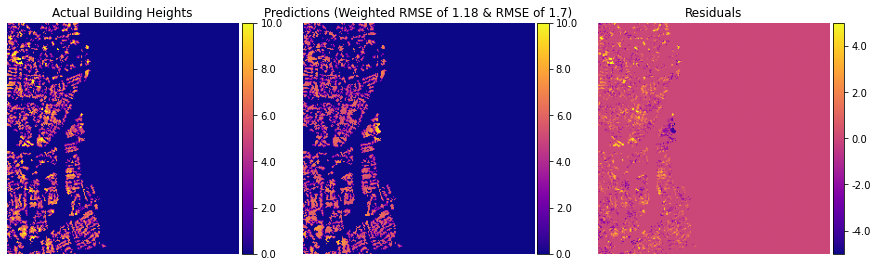

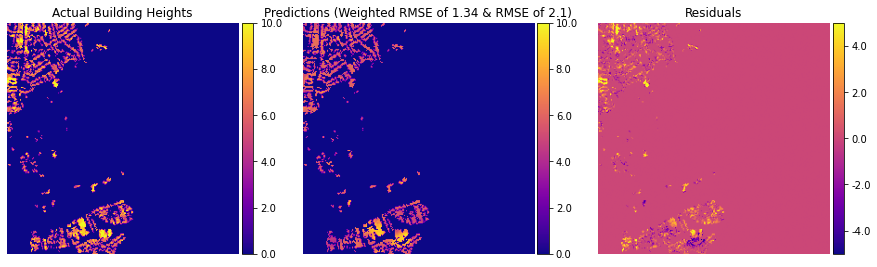

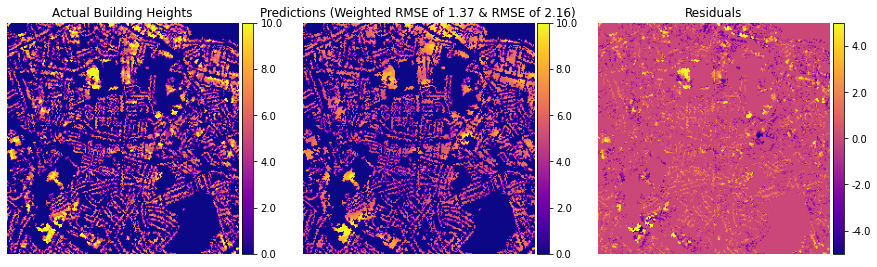

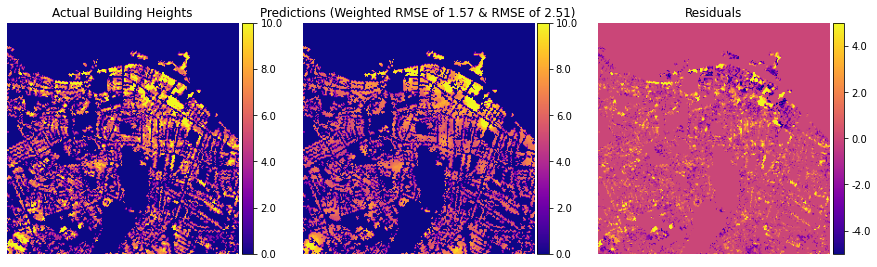

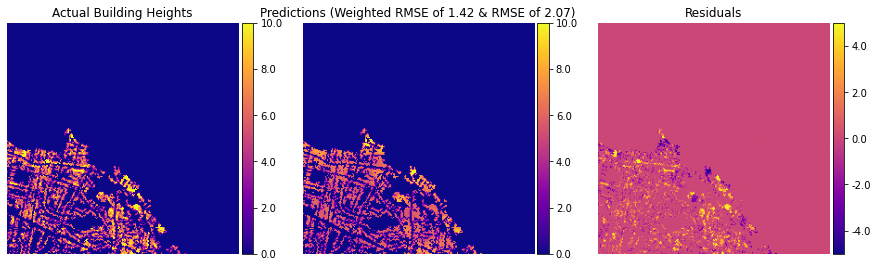

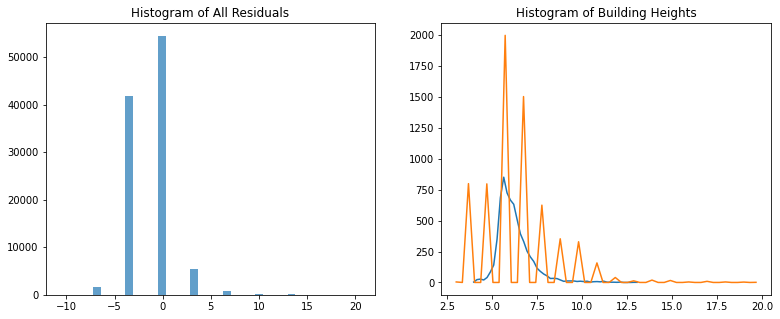

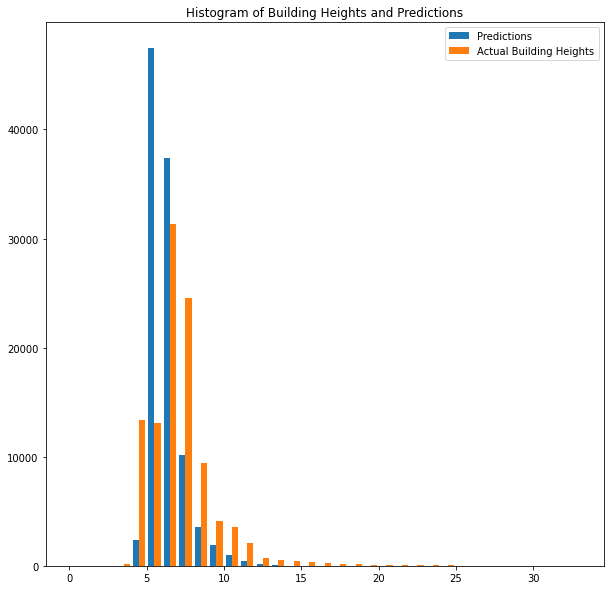

In [24]:
features = ['2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_CLS_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0002_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0003_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0005_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_ERO_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0009_ERO_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0004_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0008_GRD_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_OPN_asc',
            '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc',
            '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_BHT','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0011_CLS','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0001_CLS','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0012_CLS',
            '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0007_DIL','2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0004_DIL','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0009_DIL',
            '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0005_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0003_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO','2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0003_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0007_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_SW2_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0006_ERO',
            '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0012_ERO','2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_GRD',
            '2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0011_GRD',
            '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_OPN','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0012_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0012_OPN',
            '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_OPN','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN',
            ]


feature_order = ['2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_GRD','2020-2020_001-365_HL_TSA_SEN2L_NDV_STM_B0007_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_OPN_asc','2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0002_CLS',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_GRD_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0011_CLS_asc','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0008_OPN',
                 '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_OPN','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_DIL_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0012_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0002_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_DIL_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0002_GRD_asc','2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0001_DIL',
                 '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0005_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0002_DIL_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_DIL_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_DIL_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0012_OPN','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0003_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0003_ERO_asc','2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0012_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0005_DIL_asc','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0007_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_BNR_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0006_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0005_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_DIL_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0007_DIL','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0004_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_GRN_STM_B0004_GRD','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_OPN_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0004_DIL','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0012_OPN',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW2_STM_B0002_ERO','2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0009_DIL',
                 '2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0006_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDW_STM_B0013_OPN','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0003_DIL_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCW_STM_B0007_GRD','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0011_GRD','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0004_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0012_CLS','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0008_GRD_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0012_GRD_asc','2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0001_CLS',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_OPN','2020-2020_001-365_HL_TSA_SEN2L_TCG_STM_B0003_BHT',
                 '2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0003_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0002_CLS',
                 '2020-2020_001-365_HL_TSA_SEN2L_NDB_STM_B0011_CLS','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0009_ERO_asc',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_CLS_asc','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0007_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0013_ERO','2020-2020_001-365_HL_TSA_SEN2L_SW1_STM_B0004_ERO',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_ERO','2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0001_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE1_STM_B0011_OPN','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0001_CLS_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_TCB_STM_B0004_ERO','2020-2020_001-365_HL_TSA_SEN2L_NIR_STM_B0001_ERO',
                 '2020-2020_001-365_HL_TSA_VVVHP_BVV_STM_B0007_OPN_asc','2020-2020_001-365_HL_TSA_VVVHP_BVH_STM_B0007_GRD_asc',
                 '2020-2020_001-365_HL_TSA_SEN2L_RE2_STM_B0008_ERO']


def read_in_test_data_from_dir(dim=(250,250), X_n_channels=73, 
                               y_n_channels=1,
                               
                               X_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/X_test/',
                               y_test_dir='C:/Users/egnke/PythonCode/Met_Eireann_git/Ireland_building_heights/Modelling/DataSetCreation/Pixel-Wise-Data/Y_test/',
                
                              ):
    
    # Initialization      
    list_IDs_temp = read_in_list_of_ids(X_test_dir)
    batch_size = len(list_IDs_temp)
    X = np.empty((batch_size, *dim, X_n_channels))
    y = np.empty((batch_size, *dim, y_n_channels))


    # Generate data
    for i, ID in enumerate(list_IDs_temp):

        # Store sample
        X[i,] = np.load(X_test_dir + 'X_' + ID)

        # Store class
        temp_y = np.load(y_test_dir + 'Y_' + ID)

        # replace missing values with a height of 0 
        y[i,] = np.where(temp_y==-32767.0, 0, temp_y) 



    return X, y


def read_in_list_of_ids(directory):
    '''
    the format of image names is as follows for both X and Y X/Y_TileId_X1_X2_Y1_Y2.npy
    create a list from either directory as follows _TileId_X1_X2_Y1_Y2.npy
    so that we can shuffle and select image pairs in the image generator.
    '''
    list_of_ids = []

    for filepath in glob.glob(directory + '*.npy'):
        filename = filepath.split('\\')[1]
        parsed_filename = '_'.join(filename.split('_')[1:])
        list_of_ids.append(parsed_filename)

    return list_of_ids


def replace_value_with_frequency_of_occurance(array):

    unique_elements, counts_elements = np.unique(array, return_counts=True)
    mapping = dict(zip(unique_elements, counts_elements))
    
    return np.vectorize(mapping.get)(array)



def error_from_2D(y_actual, y_pred):
    
    y_actual = y_actual.flatten()
    y_pred   = y_pred.flatten()
    
    y_pred   = y_pred[y_actual > 0]
    y_actual = y_actual[y_actual > 0]
   
    weights = replace_value_with_frequency_of_occurance(y_actual)
    WRMSE = np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))
    MSE = np.square(np.subtract(y_actual,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    
    return round(RMSE,2), round(WRMSE,2)



def error_from_1D(y_actual, y_pred):
    MSE = np.square(np.subtract(y_actual,y_pred)).mean() 
    RMSE = math.sqrt(MSE)
    
    weights = replace_value_with_frequency_of_occurance(y_actual)
    WRMSE = np.sqrt(np.sum(weights * ((y_pred - y_actual) ** 2)) / np.sum(weights))
    
    return RMSE, WRMSE


def load_model(filename):
    '''
    load the xgboost model
    '''
    model = XGBRegressor()
    model.load_model(filename)
    return model



def make_segment_wide_prediction(img_volume, building_heights, model, features):
    '''
    loop through an image pixel by pixel and make predictions
    save these predictions in a numpy array
    '''
    width, height, channels = img_volume.shape
    predictions = np.zeros((width, height, 1))
    
    for point_X in range(width):
        for point_Y in range(height):
        
            # if building height map non zero than make a prediction
            if building_heights[point_X,point_Y,0] > 0:
                pixel = img_volume[point_X,point_Y,:]
                pixel_data = pd.DataFrame(data=[pixel], columns=features)[feature_order]
                #predictions[point_X, point_Y,0] = model.predict(pixel_data)
                
                preds = model.predict(pixel_data)
                predictions[point_X, point_Y,0] = yeo_johnson.inverse_transform(preds.reshape(1, -1)).reshape(-1)
    
    
    return predictions



def visulaize_predictions(model, features):
    
    X_values, y_values = read_in_test_data_from_dir()

    
    all_preds = []
    all_true  = []
    all_residuals = []
    for (X, y) in zip(X_values, y_values):
            
        preds = make_segment_wide_prediction(X, y, model, features)
        height_image = y
        residuals = height_image-preds
        
        error_rmse, error_wrmse = error_from_2D(height_image, preds)
        
        # store predictions for below
        y_actual = height_image.flatten()
        y_pred   = preds.flatten()

        y_pred   = y_pred[y_actual > 0]
        y_actual = y_actual[y_actual > 0]
        
        all_preds.append(y_pred)
        all_true.append(y_actual)
                
        fig = plt.figure(figsize=(15, 15))
        
        ax1 = fig.add_subplot(1,3,1)
        ax1.axis('off')
        ax1.set_title("Actual Building Heights")
        img1 = ax1.imshow(height_image, vmin=0, vmax=10, cmap='plasma')
        
        ax2 = fig.add_subplot(1,3,2)
        ax2.axis('off')
        ax2.set_title(f"Predictions (Weighted RMSE of {error_wrmse} & RMSE of {error_rmse})")
        img2 = ax2.imshow(preds, vmin=0, vmax=10, cmap='plasma')
        
        
        ax3 = fig.add_subplot(1,3,3)
        ax3.axis('off')
        ax3.set_title(f"Residuals")
        img3 = ax3.imshow(residuals, vmin=-5, vmax=5, cmap='plasma')
        
        
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider1 = make_axes_locatable(ax1)
        cax1 = divider1.append_axes("right", size="5%", pad=0.05)
        
        divider2 = make_axes_locatable(ax2)
        cax2 = divider2.append_axes("right", size="5%", pad=0.05)
        
        divider3 = make_axes_locatable(ax3)
        cax3 = divider3.append_axes("right", size="5%", pad=0.05)

        
        fig.colorbar(img1,cax=cax1,  format='%.1f')
        fig.colorbar(img2,cax=cax2,  format='%.1f')
        fig.colorbar(img3,cax=cax3,  format='%.1f')

    
    flat_all_preds = [item for sublist in all_preds for item in sublist]
    flat_all_true  = [item for sublist in all_true for item in sublist]
    
    flat_all_true = np.array(flat_all_true)
    flat_all_preds = np.array(flat_all_preds)
    
    RMSE, WRMSE = error_from_1D(flat_all_true,flat_all_preds)
    residuals = flat_all_true-flat_all_preds
    
    print('-----------------------------------------------------------------------------------------------')
    print(f'Total RMSE is: {RMSE}')
    print(f'Total WRMSE is: {WRMSE}')
    
    fig2 = plt.figure(figsize=(13, 5))
        
    ax4 = fig2.add_subplot(1,2,1)
    ax4.set_title(f"Histogram of All Residuals")
    hist, bin_edges = np.histogram(residuals)
    ax4.bar(bin_edges[:-1], hist, alpha=0.7)


    ax5 = fig2.add_subplot(1,2,2)
    ax5.set_title(f"Histogram of Building Heights")

    height_image = height_image.flatten()
    preds = preds.flatten()

    preds  = preds[height_image > 0]
    height_image  = height_image[height_image > 0]

    hist_preds, bin_edges_preds   = np.histogram(preds, 50)
    hist_actual, bin_edges_actual = np.histogram(height_image, 50)

    ax5.plot(bin_edges_preds[:-1], hist_preds)
    ax5.plot(bin_edges_actual[:-1], hist_actual)
    
    fig3 = plt.figure(figsize=(10, 10))
    plt.title(f"Histogram of Building Heights and Predictions")
    bins = np.arange(0,max(flat_all_true))
    plt.hist([flat_all_preds, flat_all_true], bins, label=['Predictions', 'Actual Building Heights'])
    plt.legend(loc='upper right')
    
    
    fig4 = plt.figure(figsize=(10, 10))
    plt.title(f"Residual Plot")
    plt.scatter(residuals, flat_all_preds)


        
       
        
#xgb_test = load_model("xgb_building_height.json")
visulaize_predictions(model=xgb, features=features)

-----------------------------------------------------------------------------------------------
Total RMSE is: 3.206742405329567
Total WRMSE is: 2.508812606385867


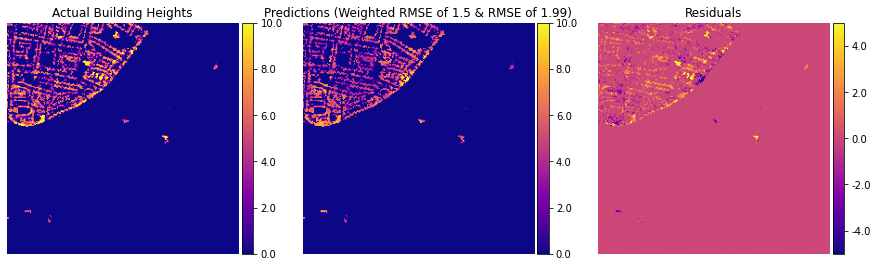

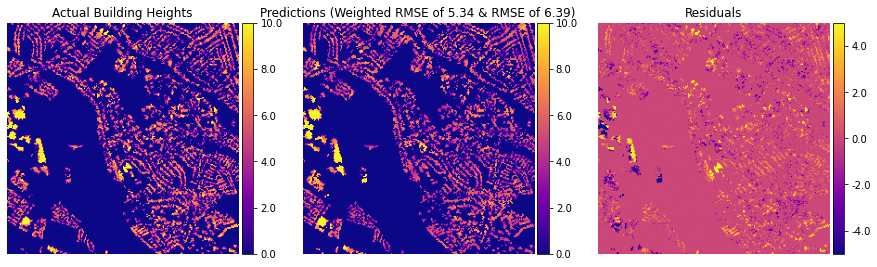

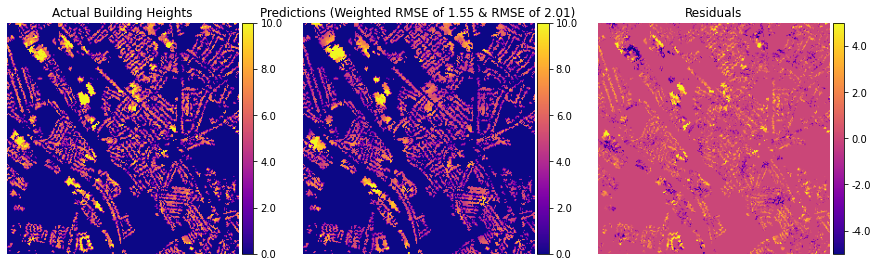

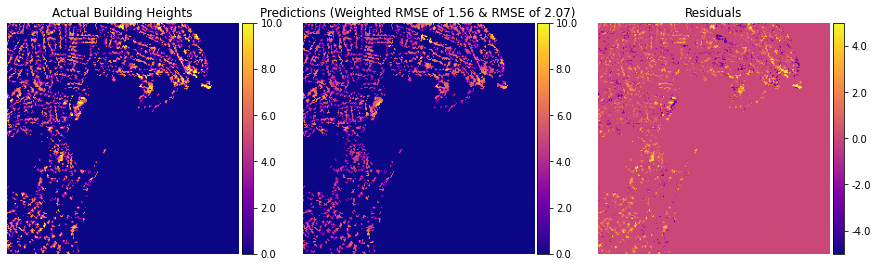

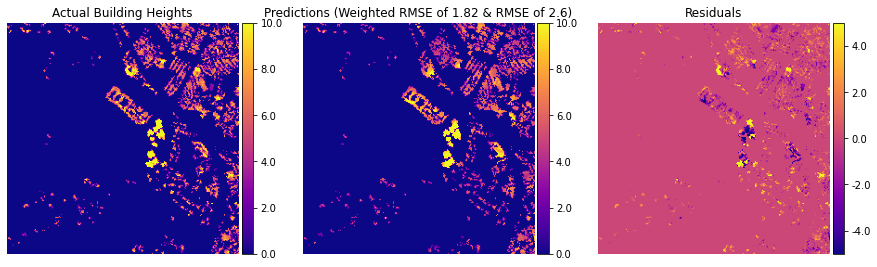

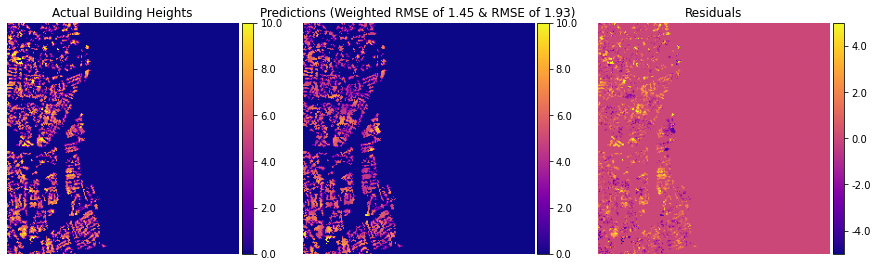

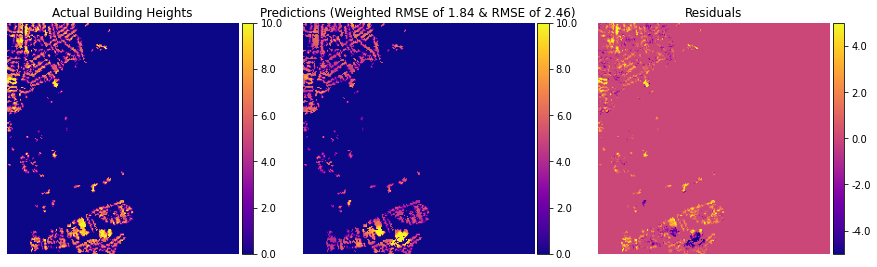

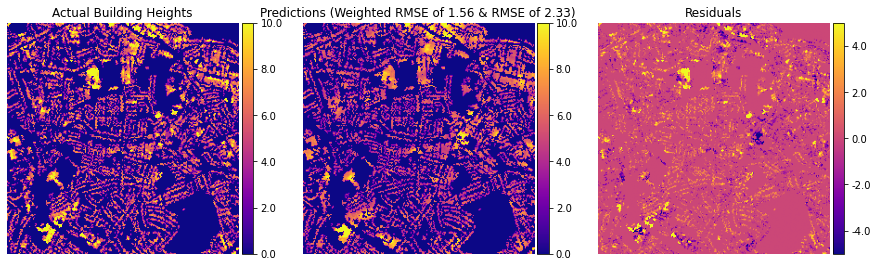

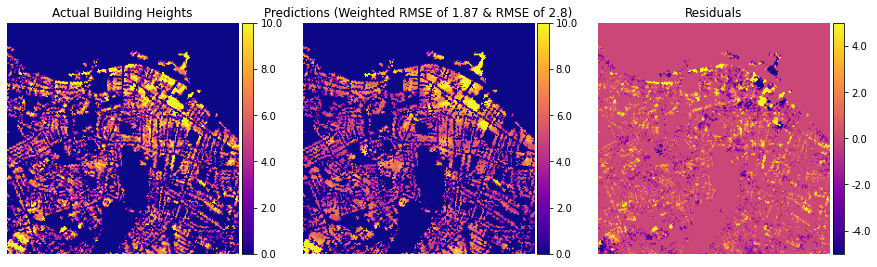

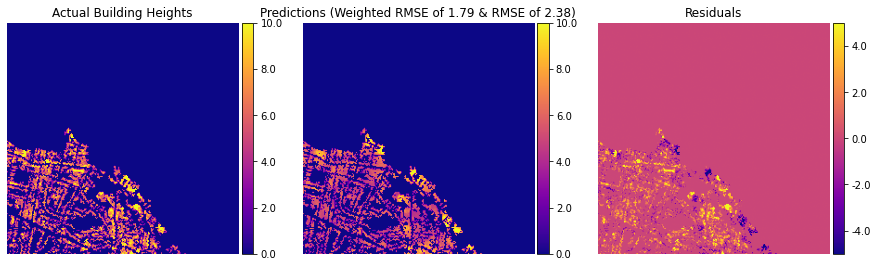

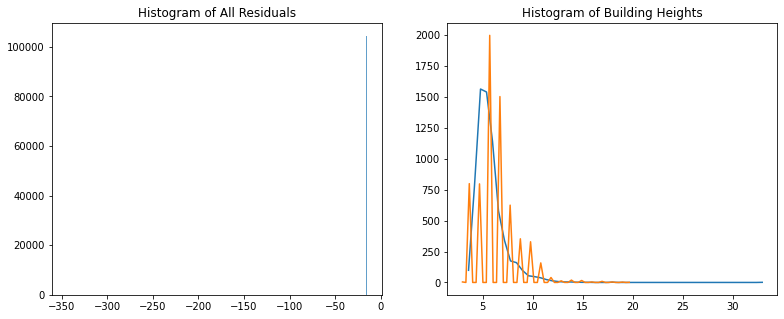

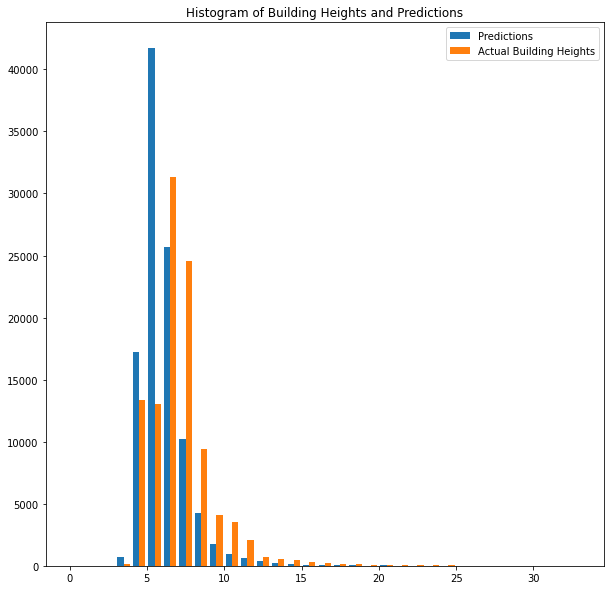

In [25]:
visulaize_predictions(model=linear_model, features=features)